<a href="https://colab.research.google.com/github/CesarAugusto88/PDI/blob/main/Segmention_and_Classification_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cesar Augusto de Moraes Costa
### Source:
```
https://www.youtube.com/watch?v=9SnFCjc9g-w&list=PLzHdTn7Pdxs6R6gf-0aLCqy8pL1GazPEe&index=9
```



In [1]:
# importing data
!gdown --id 1A1PdLYZ8C-WeM1MlWLv6dSj2yZR8Bu7S
!gdown --id 1dFAiKUhjmsZVny52Kaxo6PJBZm5EbnY4
!gdown --id 1XbyaBGzYoGQLCKa-4PAbEuA7Doue0s0i
!gdown --id 146c83uOEy-ep_PtoRXiReLSGX68lM6T5
!gdown --id 1ManUn9-sOVYbDcsGSEcMFDQqt6LnbS4y

!gdown --id 139XYm5irDHy3QBwBxJmat9PNCe3gWozQ
!gdown --id 1zglwC24nnUPrufNOFLq2xhI6vv0yTYfm
!gdown --id 1iy3s4CLZuou979MUbkU2QO76ViqZdkPn
!gdown --id 1HkKxnYdjID28xJD8vD0SHqOVwdiqs4GB
!gdown --id 1bYrIXqPRqxXo2Z7cA4P7laHolHku9LQW

# pansharpening
!gdown --id 1ER7V68nXfx28vzDNpCrIG1Ev8iIbIwHt

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1A1PdLYZ8C-WeM1MlWLv6dSj2yZR8Bu7S
To: /content/pan_recorte.shp
100% 24.6M/24.6M [00:00<00:00, 35.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dFAiKUhjmsZVny52Kaxo6PJBZm5EbnY4
To: /content/pan_recorte.shx
100% 1.38M/1.38M [00:00<00:00, 75.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
F

In [2]:
# install libraries
# !nvidia-smi # GPU
!pip install geopandas
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 16.7 MB 447 kB/s 
     |████████████████████████████████| 6.3 MB 30.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdal
import ogr

from skimage import exposure
from skimage.segmentation import quickshift, slic
from skimage import segmentation
import time
import scipy
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, plot_confusion_matrix)
from sklearn.model_selection import train_test_split

# Rasterize Training Data

Paste the highlighted lines at the end of the obia.py file created during image segmentation. Code (obia.py) from Part 1 of the tutorial can be accessed at this link: https://opensourceoptions.com/blog/python-geographic-object-based-image-analysis-geobia/ 

In [4]:
# OBIA
# open NAIP image as a gdal raster dataset
# naip_fn = '/content/recorte_merge_composicao_colorida.tif' 
naip_fn = '/content/pansharpening_corte1_sjcampos.tif' 

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
nbands = naip_ds.RasterCount
band_data = []
print('bands', naip_ds.RasterCount, 'rows', naip_ds.RasterYSize, 'columns', naip_ds.RasterXSize)
for i in range(1, nbands+1):
  band = naip_ds.GetRasterBand(i).ReadAsArray()
  band_data.append(band)
band_data = np.dstack(band_data)  # b for b in band_data
# print(band_data.shape)
img = exposure.rescale_intensity(band_data)

seg_start = time.time()
segments = quickshift(img.astype("double"), convert2lab=False)
# segments = quickshift(img.astype("double"), ratio=0.8, convert2lab=False)
# segments = slic(img, n_segments=100000, compactness=0.1)
# segments = slic(img, n_segments=500000, compactness=0.01)
# segments = quickshift(img.astype("double"), ratio=0.99, max_dist=5, convert2lab=False)
# segments = slic(img, n_segments=500000, compactness=0.1)
print('segments complete', time.time() - seg_start)

def segment_features(segment_pixels):
  features = []
  npixels, nbands = segment_pixels.shape
  for b in range(nbands):
    stats = scipy.stats.describe(segment_pixels[:,b])
    band_stats = list(stats.minmax) + list(stats)[2:]
    if npixels == 1:
      # in this case the variance = nan, change it 0.0
      band_stats[3] = 0.0
    features += band_stats
  return features

obj_start = time.time()
segment_ids = np.unique(segments)
objects = []
objects_ids = []
for id in segment_ids:
  segment_pixels = img[segments == id]
  print('pixels for id', id, segment_pixels.shape)
  object_features = segment_features(segment_pixels)
  objects.append(object_features)
  objects_ids.append(id)

print('created', len(objects), 'objects with', len(objects[0]), 'variables in',
      time.time()-obj_start, 'seconds')

# save segments to raster
segments_fn = '/content/segments_final.tif'
segments_ds = driverTiff.Create(segments_fn, naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_Float32)
segments_ds.SetGeoTransform(naip_ds.GetGeoTransform())
segments_ds.SetProjection(naip_ds.GetProjectionRef())
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None

bands 4 rows 450 columns 554
segments complete 10.417582035064697
pixels for id 0 (1175, 4)
pixels for id 1 (485, 4)
pixels for id 2 (2244, 4)
pixels for id 3 (1228, 4)
pixels for id 4 (1501, 4)
pixels for id 5 (2737, 4)
pixels for id 6 (721, 4)
pixels for id 7 (2721, 4)
pixels for id 8 (3358, 4)
pixels for id 9 (1289, 4)
pixels for id 10 (995, 4)
pixels for id 11 (1371, 4)
pixels for id 12 (795, 4)
pixels for id 13 (632, 4)
pixels for id 14 (313, 4)
pixels for id 15 (3178, 4)
pixels for id 16 (898, 4)
pixels for id 17 (2895, 4)
pixels for id 18 (333, 4)
pixels for id 19 (757, 4)
pixels for id 20 (2372, 4)
pixels for id 21 (1477, 4)
pixels for id 22 (908, 4)
pixels for id 23 (121, 4)
pixels for id 24 (582, 4)
pixels for id 25 (786, 4)
pixels for id 26 (1197, 4)
pixels for id 27 (4258, 4)
pixels for id 28 (925, 4)
pixels for id 29 (379, 4)
pixels for id 30 (688, 4)
pixels for id 31 (3444, 4)
pixels for id 32 (2418, 4)
pixels for id 33 (282, 4)
pixels for id 34 (378, 4)
pixels for id 35 

In [5]:
# read shapefile to geopandas geodataframe
# https://www.youtube.com/watch?v=p4hVA5dvV0g&list=PLzHdTn7Pdxs6R6gf-0aLCqy8pL1GazPEe&index=9
gdf = gpd.read_file('/content/truth_data.shp')
gdf

,ktype,geometry
0,agua,POINT (396890.488 7439395.464)
1,agua,POINT (397012.515 7439403.851)
2,agua,POINT (396889.797 7439495.421)
3,agua,POINT (397303.494 7438938.111)
4,agua,POINT (396801.606 7438881.836)
5,agua,POINT (396982.671 7439684.670)
6,agua,POINT (397087.168 7438947.936)
7,arvore,POINT (397184.649 7439354.115)
8,arvore,POINT (397065.551 7439426.850)
9,arvore,POINT (396835.275 7439687.424)


In [6]:
# get names of land cover classes/labels
class_names = gdf['ktype'].unique()
print('class names', class_names)

class names ['agua' 'arvore' 'construcao' 'grama']


In [7]:
# create a unique id (integer) for each land cover class/label
class_ids = np.arange(class_names.size) + 1
print('class ids', class_ids)

class ids [1 2 3 4]


In [8]:
# create a pandas data frame of the labels and ids and save to csv
df = pd.DataFrame({'ktype': class_names, 'id': class_ids})
df.to_csv('/content/class_lookup.csv')
print('gdf without ids', gdf.head())
gdf['id'] = gdf['ktype'].map(dict(zip(class_names, class_ids)))
print('gdf whith ids', gdf.head())

gdf without ids   ktype                        geometry
0  agua  POINT (396890.488 7439395.464)
1  agua  POINT (397012.515 7439403.851)
2  agua  POINT (396889.797 7439495.421)
3  agua  POINT (397303.494 7438938.111)
4  agua  POINT (396801.606 7438881.836)
gdf whith ids   ktype                        geometry  id
0  agua  POINT (396890.488 7439395.464)   1
1  agua  POINT (397012.515 7439403.851)   1
2  agua  POINT (396889.797 7439495.421)   1
3  agua  POINT (397303.494 7438938.111)   1
4  agua  POINT (396801.606 7438881.836)   1


In [9]:
# split the truth data into training and test data sets and save each to a new shapefile
gdf_train = gdf.sample(frac=0.7)
gdf_test = gdf.drop(gdf_train.index)
print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test', gdf_test.shape)

gdf shape (54, 3) training shape (38, 3) test (16, 3)


In [10]:
gdf_train.to_file('/content/train.shp')
gdf_test.to_file('/content/test.shp')

### Train and Classify image


In [11]:
train_fn = '/content/train.shp'
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
# retrieve the rasterized data and print basic stats
data = target_ds.GetRasterBand(1).ReadAsArray()
print('min', data.min(), 'max', data.max(), 'mean', data.mean())

ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

classes = np.unique(ground_truth)[1:]
print('class values', classes)

segments_per_class = {}

for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)
    print("Training segments for class", klass, ":", len(segments_of_class))

intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0, "Segment(s) represent multiple classes"

###### Classify the image  #####
train_img = np.copy(segments)
threshold = train_img.max() + 1

for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label

train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

training_objects = []
training_labels  = []

for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object
    print('Training objects for class', klass, ':', len(class_train_object))

classifier = RandomForestClassifier(n_jobs=-1, n_estimators=322)  # n_estimators=200, max_depth=5, random_state=2
classifier.fit(training_objects, training_labels)
print('Fitting Random Forest Classifier')
predicted = classifier.predict(objects)
print('Predicting Classifications')

#################### MLPClassifier #############################
mlp = MLPClassifier(hidden_layer_sizes=(50,100 ), activation='relu', solver='adam', 
                   alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, max_iter=200,  
                    verbose=True,  
                    momentum=0.9, early_stopping=True, 
                    validation_fraction=0.1, n_iter_no_change=9)
mlp.fit(training_objects, training_labels)
predict = mlp.predict(objects)
##################################################################                    

clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass
print('Prediction applied to numpy array')
clf_mlp = np.copy(segments)
for segment_id, klass in zip(segment_ids, predict):
    clf_mlp[clf_mlp == segment_id] = klass
print('Prediction applied to numpy array mlp')

mask = np.sum(img, axis=2)
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0
clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0

##### MLP ###########
clf_mlp = np.multiply(clf_mlp, mask)
clf_mlp[clf_mlp < 0] = -9999.0
##################

print('Saving classificaiton to raster with gdal')

clfds = driverTiff.Create('/content/classified.tif', naip_ds.RasterXSize, naip_ds.RasterYSize,
                          1, gdal.GDT_Float32)
clfds.SetGeoTransform(naip_ds.GetGeoTransform())
clfds.SetProjection(naip_ds.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(clf)
clfds = None

##### MLP ##############
clfds_mlp = driverTiff.Create('/content/classified_mlp.tif', naip_ds.RasterXSize, naip_ds.RasterYSize,
                          1, gdal.GDT_Float32)
clfds_mlp.SetGeoTransform(naip_ds.GetGeoTransform())
clfds_mlp.SetProjection(naip_ds.GetProjection())
clfds_mlp.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds_mlp.GetRasterBand(1).WriteArray(clf_mlp)
clfds_mlp = None
##########################

print('Done!')

min 0 max 4 mean 0.00039310068190934617
class values [1 2 3 4]
Training segments for class 1 : 6
Training segments for class 2 : 15
Training segments for class 3 : 6
Training segments for class 4 : 11
Training objects for class 1 : 6
Training objects for class 2 : 12
Training objects for class 3 : 5
Training objects for class 4 : 10
Fitting Random Forest Classifier
Predicting Classifications
Iteration 1, loss = 2.08147525
Validation score: 0.000000
Iteration 2, loss = 1.80758310
Validation score: 0.000000
Iteration 3, loss = 1.66897927
Validation score: 0.000000
Iteration 4, loss = 1.55005654
Validation score: 0.000000
Iteration 5, loss = 1.43351602
Validation score: 0.000000
Iteration 6, loss = 1.31861881
Validation score: 0.000000
Iteration 7, loss = 1.21255964
Validation score: 0.250000
Iteration 8, loss = 1.12497862
Validation score: 0.250000
Iteration 9, loss = 1.06455011
Validation score: 0.250000
Iteration 10, loss = 1.05843741
Validation score: 0.250000
Iteration 11, loss = 1.0

# Python Confusion Matrix for Accuracy of Random Forest Image Classification
```
https://www.youtube.com/watch?v=yEd-x6RtOEs&list=PLzHdTn7Pdxs6R6gf-0aLCqy8pL1GazPEe&index=13
```

In [12]:
# continue OBIA
# CLIPPED - recorte imagem de tamanho menor
naip_fn = '/content/pansharpening_corte1_sjcampos.tif' 

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)

test_fn = '/content/test.shp'
test_ds = ogr.Open(test_fn)
lyr = test_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)

truth = target_ds.GetRasterBand(1).ReadAsArray()

pred_ds = gdal.Open('/content/classified.tif')
pred = pred_ds.GetRasterBand(1).ReadAsArray()

pred_ds_mlp = gdal.Open('/content/classified_mlp.tif')
pred_mlp = pred_ds_mlp.GetRasterBand(1).ReadAsArray()

idx = np.nonzero(truth)

cm = confusion_matrix(truth[idx], pred[idx])

# pixel accuracy
print(cm)

print(cm.diagonal())
print(cm.sum(axis=0))

accuracy = cm.diagonal() / cm.sum(axis=0)
print(accuracy)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", accuracy_score(truth[idx], pred[idx]))

# MLP
cm_mlp = confusion_matrix(truth[idx], pred_mlp[idx])

# pixel accuracy MLP
print(cm_mlp)

print(cm_mlp.diagonal())
print(cm_mlp.sum(axis=0))

accuracy_mlp = cm_mlp.diagonal() / cm_mlp.sum(axis=0)
print(accuracy_mlp)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL MLP: ", accuracy_score(truth[idx], pred_mlp[idx]))

[[3 0 0 0]
 [0 4 0 0]
 [0 1 2 3]
 [0 1 0 2]]
[3 4 2 2]
[3 6 2 5]
[1.         0.66666667 1.         0.4       ]
ACCURACY OF THE MODEL:  0.6875
[[3 0 0 0]
 [1 3 0 0]
 [0 5 1 0]
 [1 0 2 0]]
[3 3 1 0]
[5 8 3 0]
[0.6        0.375      0.33333333        nan]
ACCURACY OF THE MODEL MLP:  0.4375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


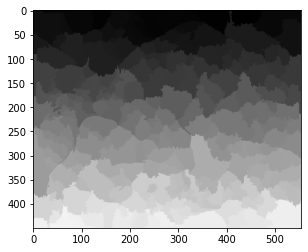

In [13]:
import matplotlib.image as mpimg

img = mpimg.imread('segments_final.tif') # segments / classifier
imgplot = plt.imshow(img)
plt.show()

############################################################################

#  Python Assign Classifications to Image Segments for Object Based Image Classification

```
https://www.youtube.com/watch?v=tRFbtCo-a6s&list=PLzHdTn7Pdxs6R6gf-0aLCqy8pL1GazPEe&index=11
```

In [14]:
# Continue OBIA
# ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

# classes = np.unique(ground_truth)[1:]
# print('class values', classes)

# segments_per_class = {}

# for klass in classes:
#     segments_of_class = segments[ground_truth == klass]
#     segments_per_class[klass] = set(segments_of_class)
#     print("Training segments for class", klass, ":", len(segments_of_class))

# intersection = set()
# accum = set()

# for class_segments in segments_per_class.values():
#     intersection |= accum.intersection(class_segments)
#     accum |= class_segments
  
# assert len(intersection) == 0, "Segment(s) represent multiple classes"


# Rasterize Shapefile Training Data for Object-Based Image Analysis with Python
```
https://www.youtube.com/watch?v=7F4n87j7XA0&list=PLzHdTn7Pdxs6R6gf-0aLCqy8pL1GazPEe&index=10
```

In [15]:
# train_fn = '/content/train.shp'
# train_ds = ogr.Open(train_fn)
# lyr = train_ds.GetLayer()
# # create a new raster layer in memory
# driver = gdal.GetDriverByName('MEM')
# target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
# target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
# target_ds.SetProjection(naip_ds.GetProjection())
# # rasterize the training points
# options = ['ATTRIBUTE=id']
# gdal.RasterizeLayer(target_ds, [1], lyr, options=options)


In [16]:
# naip_fn = '/content/pansharpening_corte1_sjcampos.tif'
# naip_ds = gdal.Open(naip_fn)

# train_fn = '/content/train.shp'
# train_ds = ogr.Open(train_fn)
# lyr = train_ds.GetLayer()
# driver = gdal.GetDriverByName('MEM')
# target_ds = driver.Create('', naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
# target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
# target_ds.SetProjection(naip_ds.GetProjection())
# options = ['ATTRIBUTE=id']
# gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
# data = target_ds.GetRasterBand(1).ReadAsArray()
# print('min', data.min(), 'max', data.max(), 'mean', data.mean())

In [17]:
# open the points file to use for training data
# train_fn = '/content/naip/train.shp'
# train_ds = ogr.Open(train_fn)
# lyr = train_ds.GetLayer()

In [18]:
# create a new raster layer in memory
# driver = gdal.GetDriverByName('MEM')
# target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
# target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
# target_ds.SetProjection(naip_ds.GetProjection())
# # rasterize the training points
# options = ['ATTRIBUTE=id']
# gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
# # retrieve the rasterized data and print basic stats
# data = target_ds.GetRasterBand(1).ReadAsArray()
# print('min', data.min(), 'max', data.max(), 'mean', data.mean())

In [19]:
## Final do artigo 
# naip_fn = '/content/tif/recorte_merge_composicao_colorida.tif'

# driverTiff = gdal.GetDriverByName('GTiff')
# naip_ds = gdal.Open(naip_fn)

# test_fn = '/content/naip/test.shp'
# # gdf_train.to_file('/content/naip/train.shp')
# # gdf_test.to_file('/content/naip/test.shp')
# test_ds = ogr.Open(test_fn)
# lyr = test_ds.GetLayer()
# driver = gdal.GetDriverByName('MEM')
# target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
# target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
# target_ds.SetProjection(naip_ds.GetProjection())
# options = ['ATTRIBUTE=id']
# gdal.RasterizeLayer(target_ds, [1], lyr, options=options)

# truth = target_ds.GetRasterBand(1).ReadAsArray()

In [20]:
# pred_ds = gdal.Open('/content/classified.tif')
# pred = pred_ds.GetRasterBand(1).ReadAsArray()

# idx = np.nonzero(truth)

# cm = metrics.confusion_matrix(truth[idx], pred[idx])
# # pixel accuracy
# print(cm)

# print(cm.diagonal())
# print(cm.sum(axis=0))

# accuracy = cm.diagonal() / cm.sum(axis=0)
# print(accuracy)